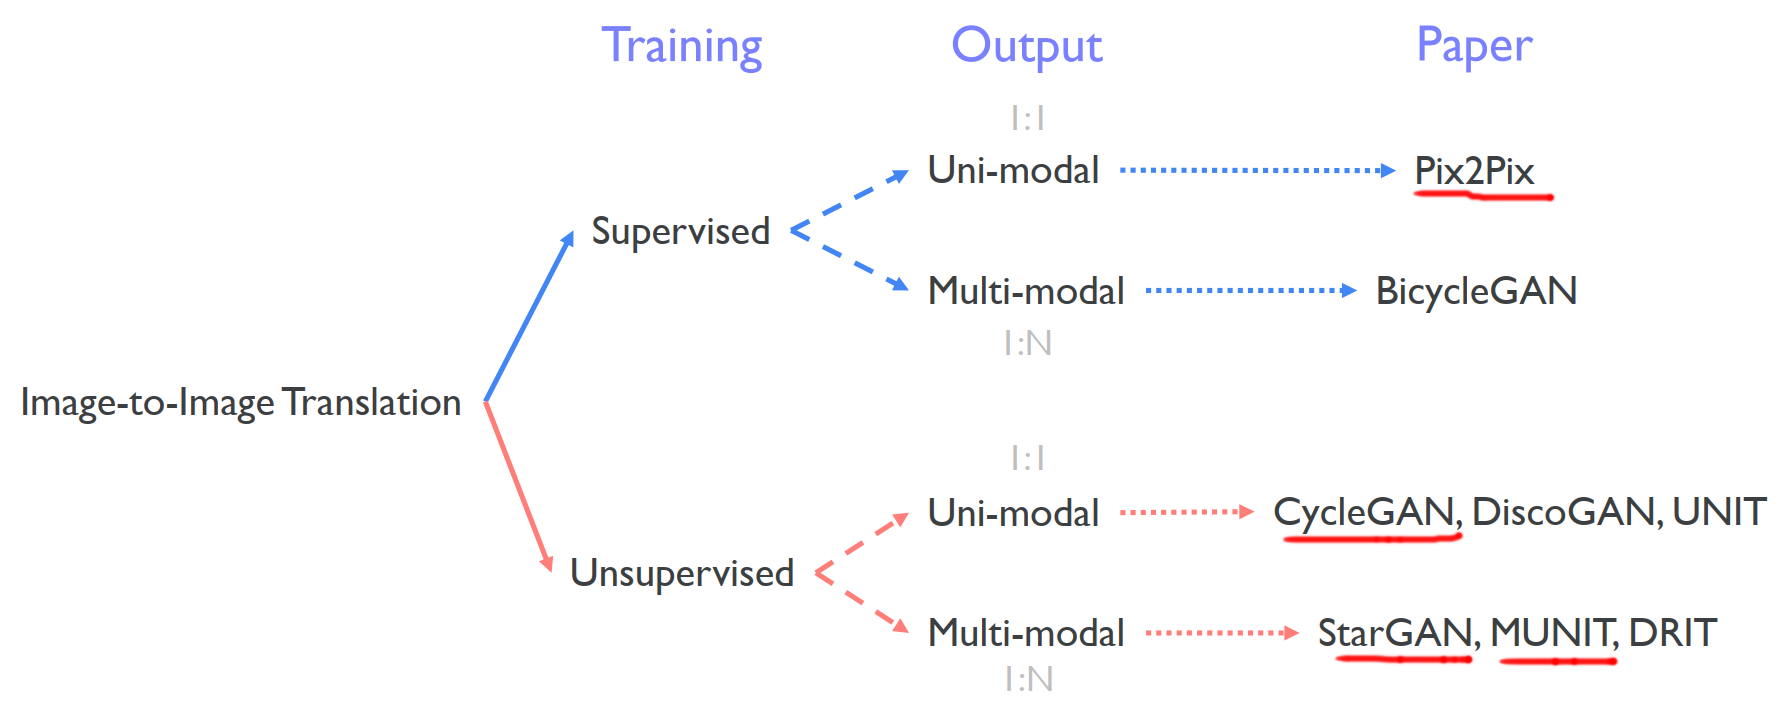

# Dataset CelebA
* CelebFaces Attributes Dataset (CelebA) bao gồm hơn 200000 ảnh người nổi tiếng, với mỗi ảnh có 40 thuộc tính như tóc đen, tóc vàng, đeo kính, đeo mũ, ...
* Thuộc tính mỗi ảnh sẽ được biểu diễn dưới dạng kiểu one-hot vector (thuộc tính nào có trong ảnh sẽ được biểu diễn 1, không có được biểu diễn 0)
* Mỗi ảnh có nhiều giá trị 1 vì mỗi ảnh có thể có nhiều thuộc tính)

# StarGAN
* Là bài toán thuộc Unsupervised Multi-modal, có thể học và chuyển đổi được nhiều domain
* Generator mang ý tưởng giống conditional GAN (cGAN) tức sẽ generate ra ảnh với condition vào điều kiện nào đấy (ở đây là các thuộc tính mình muốn chuyển đổi sang)
> 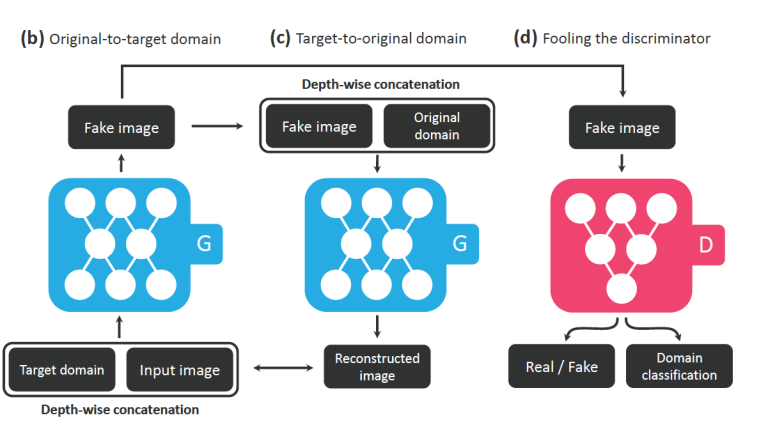
> * Input là ảnh gốc và target domain mà muốn chuyển thuộc tính sang, output là ảnh sinh ra với các target domain tương ứng
> * Sau đấy ảnh fake sinh ra sẽ kết hợp với các domain gốc ban đầu của ảnh được cho qua generator với mục đích học lại ảnh ban đầu. Ví dụ:
>     * Ảnh gốc tóc đen + domain tóc vàng $\rightarrow$ ảnh tóc vàng
>     * Sau đó ảnh tóc vàng sinh ra + domain tóc đen $\rightarrow$ ảnh tóc đen
> * Ở đây mình sẽ có construction loss, tức là ảnh sinh ra ở (c) sẽ giống với ảnh ban đầu input ở (b)
> * Discriminator thì input sẽ là 1 ảnh (ảnh fake do nhánh (b) sinh ra hoặc ảnh thật trong dataset) và sẽ phân biệt đấy là ảnh thật hay ảnh fake. Bên cạnh đó thì Discriminator còn phân loại ảnh tới đúng domain của nó (bài toán multiple classification)

* Ta thấy StarGAN model gồm duy nhất 1 mạng Generator và 1 mạng Discriminator. Có 2 điểm khác so với GAN bình thường:
    * Thứ nhất là reconstruction, phần này thì CycleGAN cũng có
    * Thứ hai là classification các domain tương ứng của mỗi ảnh để giúp StarGAN có thể học và chuyển đổi được nhiều domain

# 1. Generator
* Input generator sẽ là ảnh gốc (512, 512, 3) và 1 vector (5,) dạng one-hot thể hiện target domain
* Vector (5,) sẽ được lặp lại các giá trị thành tensor 3d kích thước (512, 512, 5) (cùng width và height với ảnh). Tưởng tượng như ở ma trận (512, 512) thì mỗi ô sẽ chứa giá trị vector (5,)
* Sau đó ảnh gốc sẽ được nối với tensor 3d sinh ra từ vector domain thành tensor 3d kích thước (512, 512, 8)
* Sau đó tensor 3d này sẽ được cho vào mô hình Generator và cho ra output ảnh màu kích thước (512, 512, 3). Mô hình giống với Pix2Pix dạng U-net và có dùng residual block

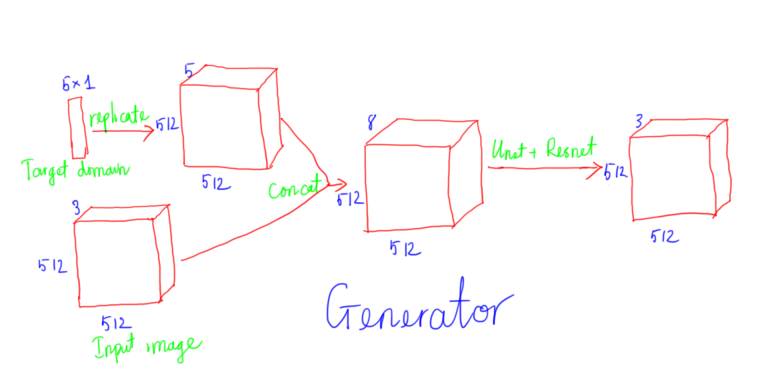

# 2. Discriminator
* Input sẽ là 1 ảnh và có 2 output:
    1. Phân biệt ảnh thật vs ảnh fake (binary classification)
    2. Phân loại ảnh đúng vs các domain của nó (multiple classification)
* Cấu trúc của Discriminator trong StarGAN giống như 1 Discriminator bình thường, tuy nhiên ở layer gần cuối sẽ cho qua 2 convolutional layers riêng để cho ra 2 outputs

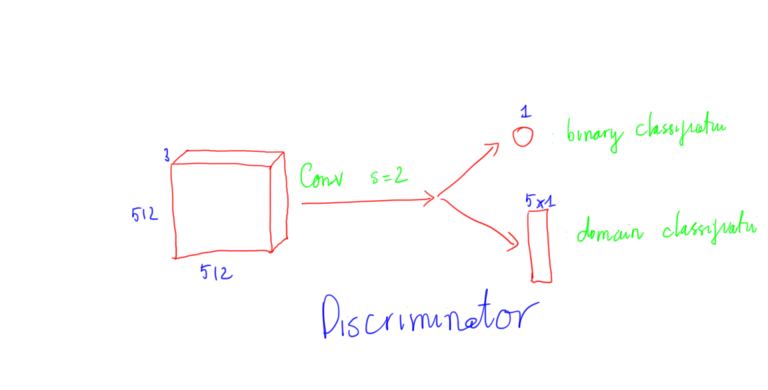

# 3. Loss function
* Các ký hiệu cơ bản:
    * $x$ là dữ liệu trong dataset CelebA
    * $c$ là target domain mà mình muốn chuyển sang
    * $c'$ là domain ban đầu ảnh
* Các loss
    * GAN loss (phân biệt ảnh thật / fake)
    > $
    \begin{equation}
        \begin{split}
            \large{\displaystyle\mathcal{L}_{gan}=\mathbb{E}_x[\log D_{src}(x)]+\mathbb{E}_{x,c}[\log (1-D_{src}(G(x,c)))]}
        \end{split}
    \end{equation}
    $
    * Classification real loss (phân loại ảnh $x$ trong dataset với các domain $c'$ tương ứng, phần $-log(D)$ là entropy loss)
    > $
    \begin{equation}
        \begin{split}
            \large{\displaystyle\mathcal{L}_{cls}^r=\mathbb{E}_{x,c'}[-\log D_{cls}(c'|x)]}
        \end{split}
    \end{equation}
    $
    * Classification fake loss (phân loại ảnh sinh ra $G(x,c)$ với các domain $c$ tương ứng)
    > $
    \begin{equation}
        \begin{split}
            \large{\displaystyle\mathcal{L}_{cls}^f=\mathbb{E}_{x,c}[-\log D_{cls}(c|G(x,c))]}
        \end{split}
    \end{equation}
    $
    * Reconstruction loss (muốn ảnh khôi phục lại khi qua generator 2 lần gần với ảnh ban đầu)
    > $
    \begin{equation}
        \begin{split}
            \large{\displaystyle\mathcal{L}_{rec}=\mathbb{E}_{x,c,c'}[\|x-G(G(x,c),c')\|_1]}
        \end{split}
    \end{equation}
    $
    * Discrimination loss bao gồm GAN loss và Classification real loss
    > $
    \begin{equation}
        \begin{split}
            \Large{\displaystyle\mathcal{L}_{D}=-\mathcal{L}_{gan}+\lambda_{cls}\mathcal{L}_{cls}^r}
        \end{split}
    \end{equation}
    $
    * Generator loss bao gồm cả GAN loss, Classification fake loss và Reconstruction loss
    > $
    \begin{equation}
        \begin{split}
        \Large{\displaystyle\mathcal{L}_{G}=\mathcal{L}_{gan}+\lambda_{cls}\mathcal{L}_{cls}^f+\lambda_{rec}\mathcal{L}_{rec}}
        \end{split}
    \end{equation}
    $
* $\normalsize{\displaystyle\lambda_{cls}}$ và $\normalsize{\displaystyle\lambda_{rec}}$ là các hyperparameter, thường $\normalsize{\displaystyle\lambda_{cls}=1}$ và $\normalsize{\displaystyle\lambda_{rec}=10}$

* [StarGAN with CelebA dataset - github repository](https://github.com/yunjey/stargan)

* [Implement StarGAN](https://github.com/eriklindernoren/PyTorch-GAN/tree/master/implementations/stargan)